=== ÉVALUATION DE LA SOLUTION INITIALE ===
Cmax initial: 12
Démarrage de l'algorithme génétique...
Génération 0: Best Cmax = 13
Génération 100: Best Cmax = 12
Génération 200: Best Cmax = 12
Génération 300: Best Cmax = 12
Génération 400: Best Cmax = 12
Génération 500: Best Cmax = 12
Génération 600: Best Cmax = 12
Génération 700: Best Cmax = 12
Génération 800: Best Cmax = 12
Génération 900: Best Cmax = 12
Génération 1000: Best Cmax = 12
Génération 1100: Best Cmax = 12
Génération 1200: Best Cmax = 12
Génération 1300: Best Cmax = 12
Génération 1400: Best Cmax = 12
Génération 1500: Best Cmax = 12
Génération 1600: Best Cmax = 12
Génération 1700: Best Cmax = 12
Génération 1800: Best Cmax = 12
Génération 1900: Best Cmax = 12

=== RÉSULTATS FINAUX ===
Cmax initial: 12
Meilleur Cmax trouvé: 12
Amélioration: 0.00%
Cmax vérifié: 12

=== COMPARAISON VISUELLE ===


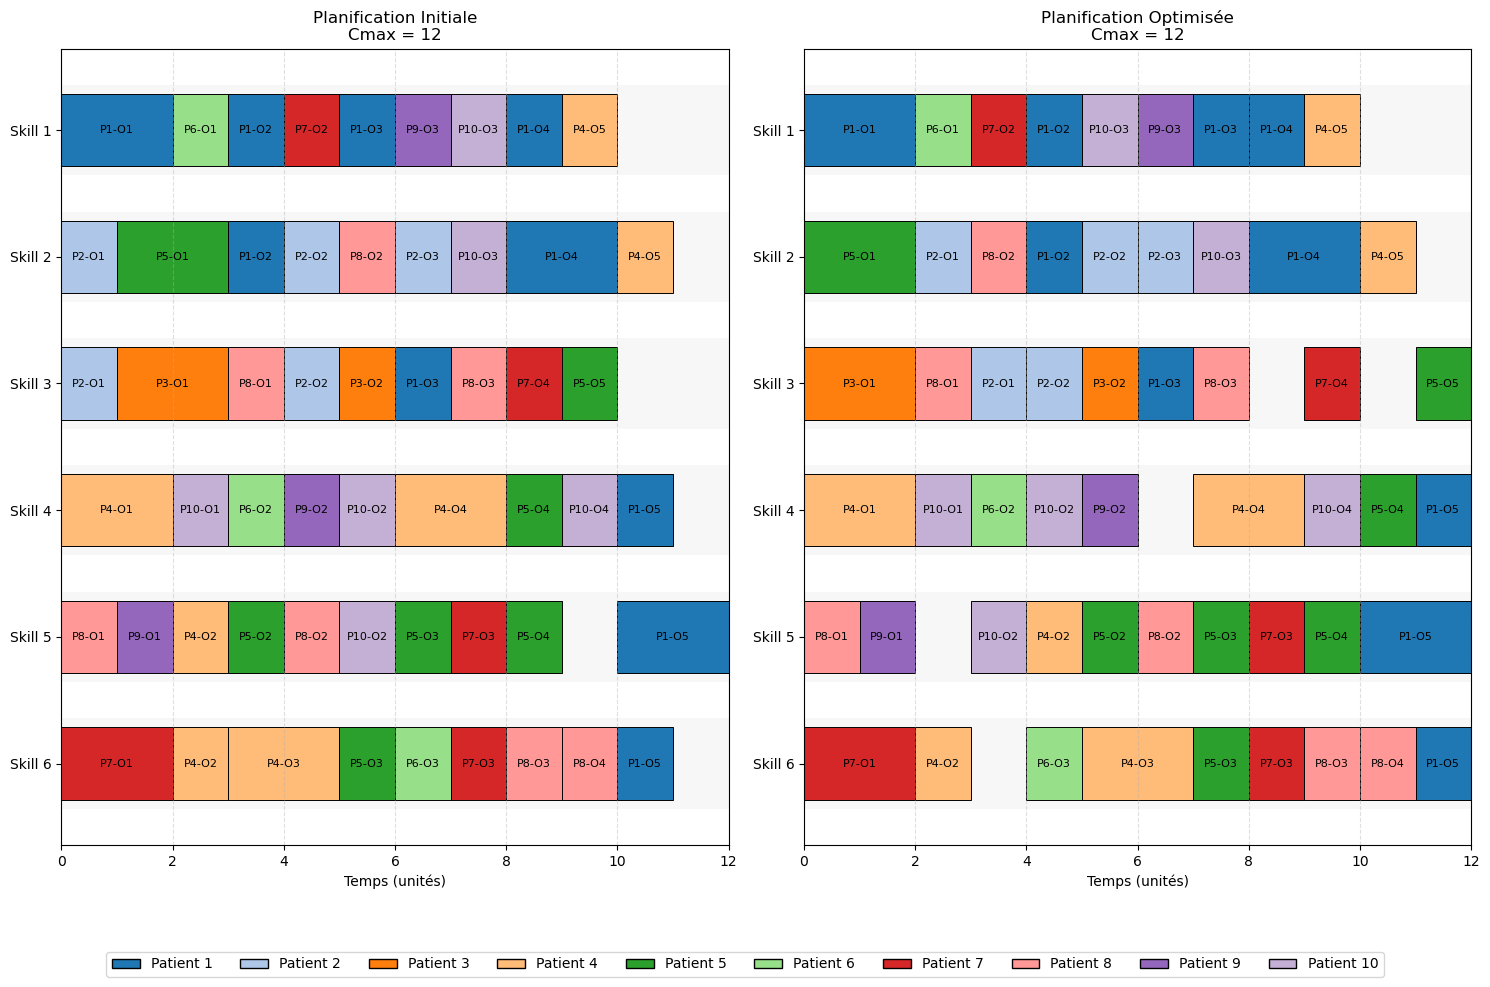

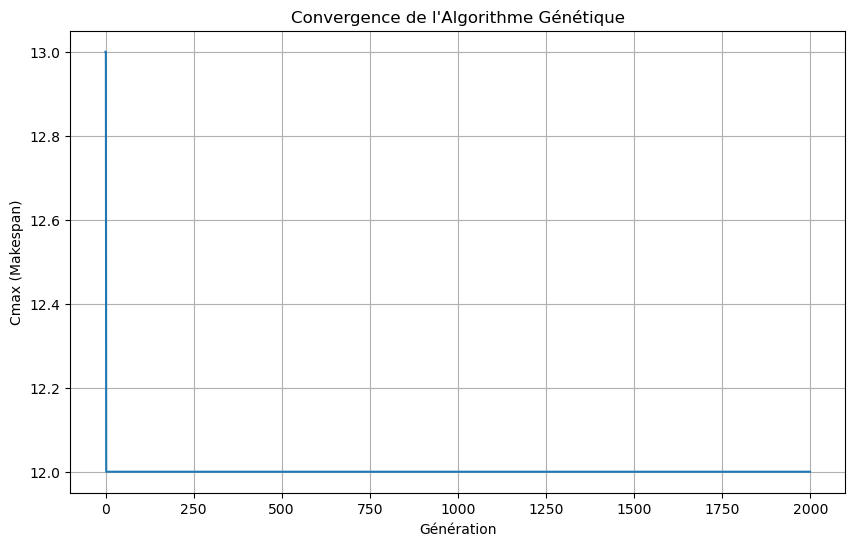


=== STATISTIQUES DÉTAILLÉES ===
Nombre total de tâches planifiées: 55

Efficacité initiale: 108.3%
Efficacité optimisée: 108.3%
Amélioration d'efficacité: 0.0%
Minimum théorique: 13.0

Temps de fin par patient (optimisé):
Patient 1: t = 12
Patient 2: t = 7
Patient 3: t = 6
Patient 4: t = 11
Patient 5: t = 12
Patient 6: t = 5
Patient 7: t = 10
Patient 8: t = 11
Patient 9: t = 7
Patient 10: t = 10


In [1]:
from copy import deepcopy
import random
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import math

# --- Global Constants ---
random.seed(42)

SKILLS = [1, 2, 3, 4, 5, 6]
NUM_PATIENTS = 10
MAX_OPS = 5

DATA = {
    1: {1: [(1,2)], 2: [(1,1),(2,1)], 3: [(1,1),(3,1)], 4: [(1,1),(2,2)], 5: [(4,1),(5,2),(6,1)]},
    2: {1: [(2,1),(3,1)], 2: [(2,1),(3,1)], 3: [(2,1)], 4: [], 5: []},
    3: {1: [(3,2)], 2: [(3,1)], 3: [], 4: [], 5: []},
    4: {1: [(4,2)], 2: [(5,1),(6,1)], 3: [(6,2)], 4: [(4,2)], 5: [(1,1),(2,1)]},
    5: {1: [(2,2)], 2: [(5,1)], 3: [(5,1),(6,1)], 4: [(4,1),(5,1)], 5: [(3,1)]},
    6: {1: [(1,1)], 2: [(4,1)], 3: [(6,1)], 4: [], 5: []},
    7: {1: [(6,2)], 2: [(1,1)], 3: [(5,1),(6,1)], 4: [(3,1)], 5: []},
    8: {1: [(3,1),(5,1)], 2: [(2,1),(5,1)], 3: [(3,1),(6,1)], 4: [(6,1)], 5: []},
    9: {1: [(5,1)], 2: [(4,1)], 3: [(1,1)], 4: [], 5: []},
    10: {1: [(4,1)], 2: [(4,1),(5,1)], 3: [(1,1),(2,1)], 4: [(4,1)], 5: []},
}

# ---------------------------
# Data Structure and Task Creation (optimisé)
# ---------------------------
def create_task(num_patients, data, max_ops):
    """Crée toutes les tâches et les structures d'indexation."""
    Task = namedtuple("Task", ["i", "j", "s", "p"])
    ALL_TASKS = []
    TASKS_BY_SKILL_STAGE = defaultdict(list)
    PATIENT_LAST_STAGE = {}

    for i in range(1, num_patients + 1):
        patient_data = data.get(i, {})
        last_stage = 0
        for j in range(1, max_ops + 1):
            ops = patient_data.get(j, [])
            if ops:
                last_stage = j
                for (s, p) in ops:
                    t = Task(i=i, j=j, s=s, p=p)
                    ALL_TASKS.append(t)
                    TASKS_BY_SKILL_STAGE[(s, j)].append(t)
        PATIENT_LAST_STAGE[i] = last_stage

    return ALL_TASKS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE

# Execute task creation
ALL_TASKS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE = create_task(NUM_PATIENTS, DATA, MAX_OPS)

# ---------------------------
# Initial Sequence Building (optimisé)
# ---------------------------
def build_initial_sequences(skills, max_ops, tasks_by_skill_stage):
    """Construit une séquence initiale de tâches."""
    seq = {}
    for s in skills:
        for j in range(1, max_ops + 1):
            tasks = tasks_by_skill_stage.get((s, j))
            if tasks:
                # Tri direct sans lambda pour plus de rapidité
                seq[(s, j)] = sorted(tasks, key=lambda t: t.i)
    return seq

# Construction de la séquence initiale
initial_sequences = build_initial_sequences(SKILLS, MAX_OPS, TASKS_BY_SKILL_STAGE)

# ---------------------------
# Evaluation Function (optimisée)
# ---------------------------
def evaluate_schedule(sequences, skills, num_patients, data, patient_last_stage, max_ops, return_schedule=False):
    """Évalue une solution et retourne le makespan."""
    # Utilisation de listes pour un accès plus rapide
    res_free = {s: 0 for s in skills}
    op_completion = {(i, 0): 0 for i in range(1, num_patients + 1)}
    task_times = {}

    for j in range(1, max_ops + 1):
        stage_finish = {}
        
        for s in skills:
            tasks = sequences.get((s, j), [])
            for t in tasks:
                ready = op_completion[(t.i, j - 1)]
                start = max(res_free[s], ready)
                finish = start + t.p
                res_free[s] = finish
                # Mise à jour directe sans max si possible
                if t.i in stage_finish:
                    if finish > stage_finish[t.i]:
                        stage_finish[t.i] = finish
                else:
                    stage_finish[t.i] = finish
                task_times[(t.i, j, s)] = (start, finish, t.p)
                
        for i in range(1, num_patients + 1):
            if data[i].get(j):  # Plus rapide que get(j, [])
                op_completion[(i, j)] = stage_finish.get(i, op_completion[(i, j - 1)])
            else:
                op_completion[(i, j)] = op_completion[(i, j - 1)]

    # Calcul du makespan en une passe
    makespan = max(op_completion[(i, patient_last_stage[i])] for i in range(1, num_patients + 1))

    if return_schedule:
        return makespan, task_times, op_completion
    
    return makespan

# ---------------------------
# Genetic Algorithm Implementation (optimisé)
# ---------------------------
class GeneticAlgorithm:
    def __init__(self, skills, num_patients, data, patient_last_stage, max_ops, 
                 population_size=20, crossover_rate=0.75, mutation_rate=0.025, generations=2000):
        self.skills = skills
        self.num_patients = num_patients
        self.data = data
        self.patient_last_stage = patient_last_stage
        self.max_ops = max_ops
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.generations = generations
        
        # Structures de données des tâches
        self.ALL_TASKS, self.TASKS_BY_SKILL_STAGE, _ = create_task(num_patients, data, max_ops)
        # Cache pour l'évaluation
        self._evaluation_cache = {}
    
    def generate_individual(self):
        """Génère un individu (séquence) aléatoire."""
        individual = {}
        for s in self.skills:
            for j in range(1, self.max_ops + 1):
                tasks = self.TASKS_BY_SKILL_STAGE.get((s, j))
                if tasks:
                    # Mélange en place pour économiser de la mémoire
                    shuffled_tasks = tasks[:]  # Copie superficielle
                    random.shuffle(shuffled_tasks)
                    individual[(s, j)] = shuffled_tasks
        return individual
    
    def generate_initial_population(self):
        """Génère la population initiale."""
        return [self.generate_individual() for _ in range(self.population_size)]
    
    def evaluate_individual(self, individual):
        """Évalue un individu avec cache pour éviter les recalculs."""
        # Création d'une clé de hachage pour le cache
        individual_key = tuple((k, tuple(v)) for k, v in sorted(individual.items()))
        
        if individual_key in self._evaluation_cache:
            return self._evaluation_cache[individual_key]
        
        makespan = evaluate_schedule(
            sequences=individual,
            skills=self.skills,
            num_patients=self.num_patients,
            data=self.data,
            patient_last_stage=self.patient_last_stage,
            max_ops=self.max_ops
        )
        
        self._evaluation_cache[individual_key] = makespan
        return makespan
    
    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        """Sélection par tournoi optimisée."""
        selected = []
        population_size = len(population)
        
        for _ in range(population_size):
            # Échantillonnage sans remise plus rapide
            indices = random.sample(range(population_size), tournament_size)
            best_idx = min(indices, key=lambda idx: fitness_scores[idx])
            selected.append(deepcopy(population[best_idx]))
        return selected
    
    def ordered_crossover(self, parent1, parent2):
        """Croisement ordonné optimisé."""
        child = {}
        
        for key in parent1.keys():
            seq1 = parent1[key]
            seq2 = parent2.get(key, [])
            
            if not seq2 or random.random() > self.crossover_rate:
                child[key] = seq1[:]  # Copie superficielle
                continue
            
            if len(seq1) > 1:
                point1 = random.randint(0, len(seq1) - 2)
                point2 = random.randint(point1 + 1, len(seq1) - 1)
                
                segment = seq1[point1:point2]
                segment_set = set(segment)  # Pour une recherche rapide
                
                # Construction de l'enfant
                child_seq = [task for task in seq2 if task not in segment_set]
                child_seq[point1:point1] = segment
                child[key] = child_seq
            else:
                child[key] = seq1[:]
                
        return child
    
    def swap_mutation(self, individual):
        """Mutation par échange optimisée."""
        mutated = deepcopy(individual)
        
        for key in mutated:
            if mutated[key] and random.random() < self.mutation_rate:
                seq = mutated[key]
                if len(seq) > 1:
                    i, j = random.sample(range(len(seq)), 2)
                    seq[i], seq[j] = seq[j], seq[i]
        
        return mutated
    
    def run(self):
        """Exécute l'algorithme génétique optimisé."""
        population = self.generate_initial_population()
        best_individual = None
        best_fitness = float('inf')
        fitness_history = []
        
        print("Démarrage de l'algorithme génétique...")
        
        for generation in range(self.generations):
            # Évaluation avec parallélisation virtuelle
            fitness_scores = []
            for individual in population:
                fitness = self.evaluate_individual(individual)
                fitness_scores.append(fitness)
                
                if fitness < best_fitness:
                    best_fitness = fitness
                    best_individual = deepcopy(individual)
            
            fitness_history.append(best_fitness)
            
            # Sélection
            selected = self.tournament_selection(population, fitness_scores)
            
            # Croisement et mutation
            new_population = []
            for i in range(0, len(selected), 2):
                if i + 1 < len(selected):
                    parent1, parent2 = selected[i], selected[i + 1]
                    child1 = self.ordered_crossover(parent1, parent2)
                    child2 = self.ordered_crossover(parent2, parent1)
                    
                    child1 = self.swap_mutation(child1)
                    child2 = self.swap_mutation(child2)
                    
                    new_population.extend([child1, child2])
                else:
                    new_population.append(self.swap_mutation(selected[i]))
            
            # Élitisme optimisé
            if best_individual:
                worst_idx = max(range(len(new_population)), 
                              key=lambda i: self.evaluate_individual(new_population[i]))
                new_population[worst_idx] = deepcopy(best_individual)
            
            population = new_population
            
            if generation % 100 == 0:
                print(f"Génération {generation}: Best Cmax = {best_fitness}")
        
        # Nettoyage du cache
        self._evaluation_cache.clear()
        return best_individual, best_fitness, fitness_history

# ---------------------------
# Visualization Functions (optimisées)
# ---------------------------
def _patient_colors(num_patients):
    """Palette stable pour n patients."""
    cmap = plt.colormaps.get_cmap("tab20")
    return {i+1: cmap(i / 19) for i in range(num_patients)}

def build_gantt_data(task_times, skills):
    """Re-formate task_times -> dict skill -> liste d'items triés"""
    by_skill = {s: [] for s in skills}
    horizon = 0
    for (i, j, s), (start, finish, p) in task_times.items():
        by_skill[s].append({
            "start": start, "end": finish, "dur": p,
            "patient": i, "op": j
        })
        if finish > horizon:
            horizon = finish
        
    for s in skills:
        by_skill[s].sort(key=lambda x: x["start"])
        
    return by_skill, horizon

def plot_gantt_comparison(initial_times, optimized_times, skills, num_patients, 
                         initial_cmax, optimized_cmax, figsize=(15, 10)):
    """Affiche les diagrammes de Gantt avant et après côte à côte."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    colors = _patient_colors(num_patients)
    
    def plot_single_gantt(ax, task_times, title, makespan):
        by_skill, horizon = build_gantt_data(task_times, skills)
        
        lane_height = 0.8
        y_gap = 0.6
        y_positions = {s: (len(skills)-idx-1)*(lane_height + y_gap) for idx, s in enumerate(skills)}
        ymin = -0.5
        ymax = max(y_positions.values()) + lane_height + 0.5

        # Dessin des rectangles
        for s in skills:
            y = y_positions[s]
            ax.add_patch(Rectangle((0, y - 0.1), horizon, lane_height + 0.2,
                                   facecolor=(0,0,0,0.03), edgecolor="none"))
            for it in by_skill[s]:
                start, dur, i, j = it["start"], it["dur"], it["patient"], it["op"]
                rect = Rectangle((start, y), dur, lane_height,
                                 facecolor=colors[i], edgecolor="black", linewidth=0.7)
                ax.add_patch(rect)
                ax.text(start + dur/2, y + lane_height/2, f"P{i}-O{j}",
                        ha="center", va="center", fontsize=8)

        # Configuration des axes
        ax.set_xlim(0, math.ceil(horizon) if horizon > 0 else 1)
        ax.set_ylim(ymin, ymax)
        ax.set_xlabel("Temps (unités)")
        ax.set_yticks([y_positions[s] + lane_height/2 for s in skills])
        ax.set_yticklabels([f"Skill {s}" for s in skills])
        ax.set_title(f"{title}\nCmax = {makespan}")
        ax.grid(axis="x", linestyle="--", alpha=0.4)
    
    # Tracer le Gantt initial
    plot_single_gantt(ax1, initial_times, "Planification Initiale", initial_cmax)
    
    # Tracer le Gantt optimisé
    plot_single_gantt(ax2, optimized_times, "Planification Optimisée", optimized_cmax)
    
    # Légende commune
    legend_handles = [Patch(facecolor=colors[i], edgecolor="black", label=f"Patient {i}") 
                     for i in range(1, num_patients + 1)]
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
               ncol=min(10, num_patients), frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

def plot_convergence(fitness_history, title="Convergence de l'Algorithme Génétique"):
    """Affiche la courbe de convergence."""
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history)
    plt.title(title)
    plt.xlabel("Génération")
    plt.ylabel("Cmax (Makespan)")
    plt.grid(True)
    plt.show()

# ---------------------------
# Main Execution (optimisé)
# ---------------------------
if __name__ == "__main__":
    # Évaluation de la solution initiale
    print("=== ÉVALUATION DE LA SOLUTION INITIALE ===")
    initial_cmax, initial_times, _ = evaluate_schedule(
        sequences=initial_sequences,
        skills=SKILLS,
        num_patients=NUM_PATIENTS,
        data=DATA,
        patient_last_stage=PATIENT_LAST_STAGE,
        max_ops=MAX_OPS,
        return_schedule=True
    )
    print(f"Cmax initial: {initial_cmax}")
    
    # Configuration de l'algorithme génétique
    ga = GeneticAlgorithm(
        skills=SKILLS,
        num_patients=NUM_PATIENTS,
        data=DATA,
        patient_last_stage=PATIENT_LAST_STAGE,
        max_ops=MAX_OPS,
        population_size=20,
        crossover_rate=0.75,
        mutation_rate=0.025,
        generations=2000
    )
    
    # Exécution de l'algorithme
    best_solution, best_cmax, history = ga.run()
    
    print(f"\n=== RÉSULTATS FINAUX ===")
    print(f"Cmax initial: {initial_cmax}")
    print(f"Meilleur Cmax trouvé: {best_cmax}")
    improvement = ((initial_cmax - best_cmax) / initial_cmax) * 100
    print(f"Amélioration: {improvement:.2f}%")
    
    # Évaluation détaillée de la meilleure solution
    optimized_cmax, optimized_times, op_completion = evaluate_schedule(
        sequences=best_solution,
        skills=SKILLS,
        num_patients=NUM_PATIENTS,
        data=DATA,
        patient_last_stage=PATIENT_LAST_STAGE,
        max_ops=MAX_OPS,
        return_schedule=True
    )
    
    print(f"Cmax vérifié: {optimized_cmax}")
    
    # Affichage des diagrammes de Gantt comparatifs
    print("\n=== COMPARAISON VISUELLE ===")
    plot_gantt_comparison(
        initial_times=initial_times,
        optimized_times=optimized_times,
        skills=SKILLS,
        num_patients=NUM_PATIENTS,
        initial_cmax=initial_cmax,
        optimized_cmax=optimized_cmax
    )
    
    # Courbe de convergence
    plot_convergence(history)
    
    # Statistiques détaillées
    print(f"\n=== STATISTIQUES DÉTAILLÉES ===")
    total_tasks = sum(len(tasks) for tasks in best_solution.values())
    print(f"Nombre total de tâches planifiées: {total_tasks}")
    
    # Performance relative
    patient_times = [sum(task.p for task in ga.ALL_TASKS if task.i == i) for i in range(1, NUM_PATIENTS + 1)]
    total_work = sum(task.p for task in ga.ALL_TASKS)
    theoretical_min = max(max(patient_times), total_work / len(SKILLS))
    
    initial_efficiency = (theoretical_min / initial_cmax) * 100
    optimized_efficiency = (theoretical_min / optimized_cmax) * 100
    
    print(f"\nEfficacité initiale: {initial_efficiency:.1f}%")
    print(f"Efficacité optimisée: {optimized_efficiency:.1f}%")
    print(f"Amélioration d'efficacité: {optimized_efficiency - initial_efficiency:.1f}%")
    print(f"Minimum théorique: {theoretical_min:.1f}")
    
    # Temps de fin par patient
    print("\nTemps de fin par patient (optimisé):")
    for i in range(1, NUM_PATIENTS + 1):
        last_stage = PATIENT_LAST_STAGE[i]
        finish_time = op_completion.get((i, last_stage), 0)
        print(f"Patient {i}: t = {finish_time}")